# Importing Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import ps_constructor
import camb
from velocileptors.LPT.lpt_rsd_fftw import LPT_RSD
from velocileptors.LPT.moment_expansion_fftw import MomentExpansion
from scipy.interpolate import UnivariateSpline
from scipy.interpolate import interp1d
import data_handling
import likelihood 
import mcmc_toolkit
import pocomc

# Generating a data vector using $\texttt{velocileptors}$

In [2]:
ini_fn = '/Users/s2223060/Desktop/primordial_features/cosmologies/desi_params_LRG1.ini'
pars = camb.read_ini(ini_fn)
As = pars.InitPower.As
ns = pars.InitPower.ns
k_norm = 0.05 #[1/Mpc]
h = pars.H0/100
results = camb.get_results(pars)
kh, z_pk, plin = results.get_matter_power_spectrum(minkh=1e-4, maxkh=100, npoints = 2000)
fs8 = results.get_fsigma8()    
s8  = results.get_sigma8()     
fz = fs8/s8
fz = fz[::-1]
print(fz)
print(z_pk)

[0.76322262]
[0.51]


In [3]:

omega_log = np.arange(2,16,1)
omega_lin = np.arange(10,160,10)

In [5]:
omega_log = np.arange(2,15,1)
omega_lin = np.arange(10,150,10)

def PK_log(k, As, ns, amp, freq,phi):
    return As*(k/0.05)**(ns-1)*(1 + np.sin(phi*np.pi+np.log(k/0.05)*freq)*amp)

def PK_lin(k, As, ns, amp, freq,phi):
    return As*(k/0.05)**(ns-1)*(1 + np.sin(phi*np.pi+k*freq)*amp)


"\nfeatures = {'lin':{\n    'pk':PK_lin,\n    'omega':omega_lin,\n    'handle:\n                 },\n    'log':{\n    'pk':PK_log,\n    'omega':omega_log,\n                 },\n    } \n\n"

In [10]:
Alin = 0.1
omega_lin = 50
phi = 0

pars.set_initial_power_function(PK_lin, args=(As, ns, Alin, omega_lin, phi))
results_feature = camb.get_results(pars)
_, _, plin_feature = results_feature.get_matter_power_spectrum(minkh=1e-4, maxkh=100, npoints = 2000)

Text(0.5, 1.0, 'CAMB Plin')

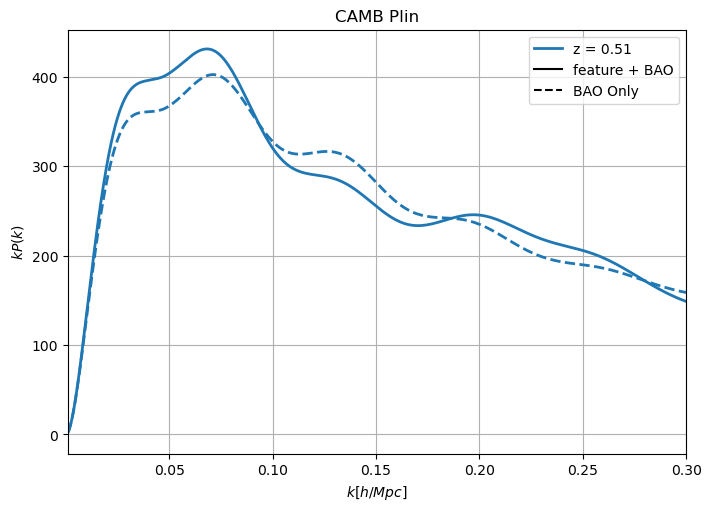

In [11]:
plt.figure(figsize = (7,5),constrained_layout=True)
for i in range(len(z_pk)):
    plt.plot(kh, kh*plin_feature[i], label = f'z = {z_pk[i]}',color = 'C'+str(i), lw = 2)
    plt.plot(kh, kh*plin[i], lw = 2,color = 'C'+str(i), ls = '--')
plt.plot([],[],color = 'black', ls = '-', label = 'feature + BAO')
plt.plot([],[],color = 'black', ls = '--', label = 'BAO Only')
plt.legend()
plt.xlim((1e-3,0.3))
plt.grid()
plt.xlabel('$ k[h/Mpc]$')
plt.ylabel('$k P(k)$')
plt.title('CAMB Plin')

In [40]:
kmin = 0.02
kmax = 0.2
data_processor = data_handling.DataProcessor(kmin, kmax)

cov_fn = "/Users/s2223060/Desktop/LSS_DATA/EZMocks/LRG/z_0.4_0.6/pre_recon/COV_desi_survey_catalogs_Y1_mocks_SecondGenMocks_EZmock_desipipe_v1_ffa_2pt_pk_pkpoles_LRG_NGC_z0.4-0.6_default_FKP_lin_nran8_cellsize6_boxsize7000_d0.001.txt"
pk_fn = "/Users/s2223060/Desktop/LSS_DATA/AbacusSummit/LRG/z_0.4_0.6/pre_recon/pk/desi_survey_catalogs_Y1_mocks_SecondGenMocks_AbacusSummit_desipipe_v4_2_ffa_2pt_mock0_pk_pkpoles_LRG_NGC_z0.4-0.6_default_FKP_lin_nran18_cellsize6_boxsize7000_d0.001.txt"
kdata,_ = data_processor.load_data_DESI(pk_fn)
COV = data_processor.load_cov(cov_fn)

#HARTLAP CORRECTION
Nmocks = 997
Nb = len(kdata)
invCOV = np.linalg.inv(COV)*10
invCOV *= (Nmocks-Nb-2)/(Nmocks-1)

In [41]:
#bias parameters from the velocileptors paper
biases = [0.71,0.26,0.67,0.52]
stoch  = [1500.,-1900.,0]
cterms = [-3.4,-1.7,6.5,0]
LPT_pars   = biases + cterms + stoch

lpt = LPT_RSD(kh,plin_feature[0],third_order=True,one_loop = True)
lpt.make_pltable(fz[0],nmax=5,apar=1,aperp=1, kv = kdata)
kl,p0_feature,p2_feature,p4_feature = lpt.combine_bias_terms_pkell(LPT_pars)

lpt = LPT_RSD(kh,plin[0],third_order=True,one_loop = True)
lpt.make_pltable(fz[0],nmax=5,apar=1,aperp=1, kv = kdata)
kl,p0,p2,p4 = lpt.combine_bias_terms_pkell(LPT_pars)

Text(0, 0.5, '$k P_0(k)$')

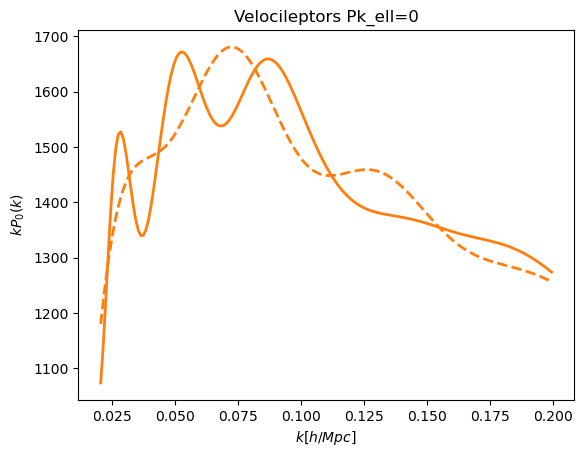

In [42]:
plt.figure()
plt.plot(kl, kl*p0_feature, label = 'feature + BAO', color = 'C1', lw = 2)
plt.plot(kl, kl*p0, label = 'feature + BAO', color = 'C1', lw = 2,ls = '--')

plt.title('Velocileptors Pk_ell=0')
plt.xlabel('$ k[h/Mpc]$')
plt.ylabel('$k P_0(k)$')

In [43]:
ps_filename = '/Users/s2223060/Desktop/primordial_features/cosmologies/power_spectrum/DESI_LRG1_plin_decomp.txt'
compressed_model = ps_constructor.PowerSpectrumConstructor(kdata, ps_filename=ps_filename, pf_model='log', ps_style='compressed')
like = likelihood.likelihoods(lambda x: compressed_model.Evaluate_bare(x), p0_feature, invCOV)

In [44]:
mcmc = mcmc_toolkit.MCMC(1, 'lin_singlepol_single_cap')

2025-05-15 14:47:49,859 - mcmc_toolkit - INFO - Using lin_singlepol_single_cap file
2025-05-15 14:47:49,861 - mcmc_toolkit - INFO - Input dictionary: OrderedDict([('B', [0.1, 8]), ('a0', [-10, 10]), ('a1', [-100, 100]), ('a2', [-200, 200]), ('a3', [-100, 100]), ('a4', [-1000, 1000]), ('alpha', [0.8, 1.2]), ('sigma_nl', [0, 15]), ('sigma_s', [0, 15]), ('A', [-5, 5]), ('omega', [0, 0]), ('phi', [-0.5, 0.5])])
2025-05-15 14:47:49,861 - mcmc_toolkit - INFO - Expanded dictionary: OrderedDict([('B', [0.1, 8]), ('a0', [-10, 10]), ('a1', [-100, 100]), ('a2', [-200, 200]), ('a3', [-100, 100]), ('a4', [-1000, 1000]), ('alpha', [0.8, 1.2]), ('sigma_nl', [0, 15]), ('sigma_s', [0, 15]), ('A', [-5, 5]), ('omega', [0, 0]), ('phi', [-0.5, 0.5])])
2025-05-15 14:47:49,862 - mcmc_toolkit - INFO - Parameter labels: ['B', 'a0', 'a1', 'a2', 'a3', 'a4', 'alpha', 'sigma_nl', 'sigma_s', 'A', 'omega', 'phi']
2025-05-15 14:47:49,864 - mcmc_toolkit - INFO - Parameter bounds: [[ 1.0e-01 -1.0e+01 -1.0e+02 -2.0e+02 

# pocoMC

In [45]:
from scipy.stats import uniform

In [46]:
mcmc.prior_bounds[0][mcmc.id_map['omega']] = 1
mcmc.prior_bounds[1][mcmc.id_map['omega']] = 50

loc = mcmc.prior_bounds[0]
scale = mcmc.prior_bounds[1] - mcmc.prior_bounds[0]
prior = pocomc.Prior([uniform(loc[i], scale[i]) for i in range(len(loc))])

In [47]:
loc = mcmc.prior_bounds[0]
scale = mcmc.prior_bounds[1] - mcmc.prior_bounds[0]
prior = pocomc.Prior([uniform(loc[i], scale[i]) for i in range(len(loc))])

In [48]:
sampler = pocomc.Sampler(
    prior=prior,
    likelihood=lambda x: like.logGaussian(x),
    vectorize=False,
    random_state=0,
    n_effective = 800,
    n_active = None
)

In [49]:
sampler.run()

Iter: 64it [26:02, 24.41s/it, beta=1, calls=308496, ESS=4078, logZ=-52.5, logP=-45.8, acc=0.209, steps=13, eff=0.982]    


In [50]:
samples, weights, logl, logp = sampler.posterior()

chi2 = -2*logl
chi2_min = chi2.min()
theta_ML = samples[chi2.argmin()]

In [51]:
theta_ML

array([ 1.09504253, -0.10780687, -2.06353725, 19.89535581, -1.68026013,
        3.50022945,  1.00448905,  8.14988645,  4.73817472,  0.09687947,
        9.90397456,  0.44415587])

In [52]:
pos_mask = samples[:,-3] > 0
neg_mask = samples[:,-3] < 0

pos_chain = samples[pos_mask]
neg_chain = samples[neg_mask]

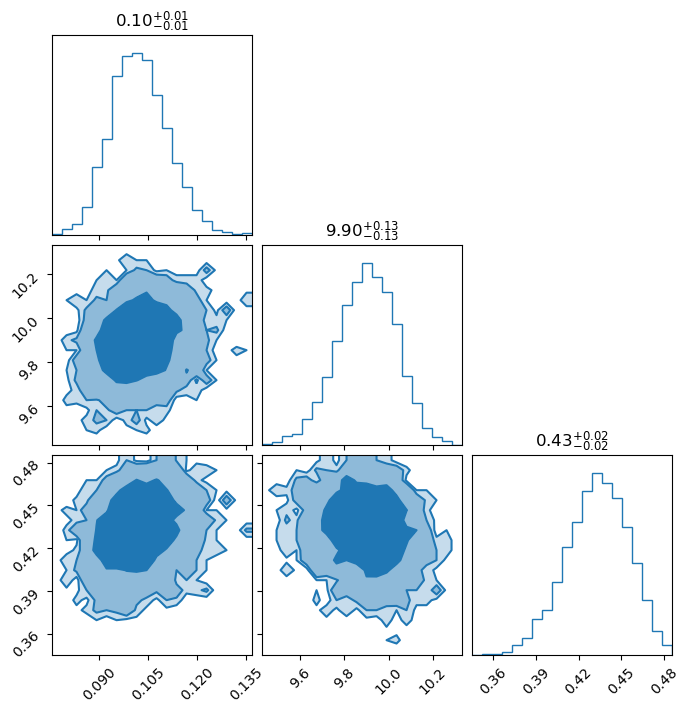

In [53]:
import corner
fig = corner.corner(samples[:, -3:], color="C0",show_titles=True, title_kwargs={"fontsize": 12}, fill_contours=True, levels=(0.68, 0.95, 0.99), plot_datapoints=False)
plt.show()

In [54]:
np.save('/Users/s2223060/Desktop/primordial_features/chains/pocoMC_logfeat_omega_10/samples_n_effective_800.npy', samples)
np.save('/Users/s2223060/Desktop/primordial_features/chains/pocoMC_logfeat_omega_10/weights_n_effective_800.npy', weights)
np.save('/Users/s2223060/Desktop/primordial_features/chains/pocoMC_logfeat_omega_10/logl_n_effective_800.npy', logl)
np.save('/Users/s2223060/Desktop/primordial_features/chains/pocoMC_logfeat_omega_10/logp_n_effective_800.npy', logp)

In [ ]:
import corner
fig = corner.corner(samples[:, -3:], color="C0",show_titles=True, title_kwargs={"fontsize": 12}, fill_contours=True, levels=(0.68, 0.95, 0.99), plot_datapoints=False)
plt.show()

In [ ]:
import corner
fig = corner.corner(samples[:, -3:], color="C0",show_titles=True, title_kwargs={"fontsize": 12}, fill_contours=True, levels=(0.68, 0.95, 0.99), plot_datapoints=False)
plt.show()

In [ ]:
import corner
fig = corner.corner(samples[:, -3:], color="C0",show_titles=True, title_kwargs={"fontsize": 12}, fill_contours=True, levels=(0.68, 0.95, 0.99), plot_datapoints=False)
plt.show()

# emcee

In [ ]:
mcmc.set_gelman_rubin({
    "N":3,
    "epsilon":0.03,
    "min_length":10000,
    "convergence_steps":10000
})

handle = f'LPT_vs_compressed_lin_omega_{omega_lin}_Alin_{Alin}'

#fix the frequency in the prior and walkers initialization
mcmc.set_walkers(20*mcmc.ndim)
mcmc.prior_bounds[0][mcmc.id_map['omega']] = 800
mcmc.prior_bounds[1][mcmc.id_map['omega']] = 1200


X0 = np.array   ([4,  0,     0,      0,     0,    0,       1,     10,      10,     0,     omega_lin,        phi])
DELTA = np.array([2, 0.001,   0.001, 0.001, 0.001, 0.001,  0.1,    5,       5,    0.1,    omega_lin*0.2,    phi*0.1])

def logposterior(theta):
    if not mcmc.in_prior(theta):
        return -np.inf
    else:
        return like.logGaussian(theta)
    
initial_positions = [mcmc.create_walkers('uniform_thin',x0=X0,delta=DELTA) for _ in range(mcmc.gelman_rubin['N'])]

In [ ]:
mcmc.run(handle, 1, initial_positions, logposterior, gelman_rubin=True, new=True, plots=True)

In [14]:
from getdist import MCSamples, plots

labels = [r'B',r"a_0", r"a_1", r"a_2", r"a_3", r"a_4", r"\alpha",r"\Sigma_{\rm nl}",r"\Sigma_s", r"A",r"\omega",r"\phi"]

In [ ]:
chain = mcmc.get_chain(handle,gelman = mcmc.gelman_rubin)

sample = MCSamples(samples=chain,
                        names=mcmc.labels, 
                        labels=labels,settings={'contours': [0.68, 0.95, 0.99],'smooth_scale_2D':0.1,
                                                'ignore_rows':0.3},)

g1 = plots.get_single_plotter(width_inch=10)
g1.settings.title_limit = 1
g1.triangle_plot(sample,['A','omega','phi'],
line_args=[{'ls':'-', 'color':'C1'}],
contour_args=[{'ls':'-', 'color':'C1'}],
marker_args={'lw': 1, 'color':'black'},filled = True,
markers={'omega':omega_lin,'A':Alin,'phi':phi},
)
#g1.export('LPT_vs_compressed_lin_omega_%s_Alin_%s.png' % (omega_lin, Alin))

In [16]:
theta_ML = mcmc.get_ML(handle,gelman_rubin=mcmc.gelman_rubin)

In [ ]:
theta_ML

In [ ]:
plt.figure()
plt.errorbar(kdata,kdata*data)
plt.plot(kdata,kdata*like.theory(theta_ML))

In [18]:
omega = chain[:,mcmc.id_map['omega']]
Amp = chain[:,mcmc.id_map['A']]
phi = chain[:,mcmc.id_map['phi']]

In [20]:
# choose number of bins (or specify your own edges)
num_bins = 5
bin_edges = np.linspace(omega.min(), omega.max(), num_bins+1)

# find which bin each ω falls into (1…num_bins)
bin_idx = np.digitize(omega, bin_edges)

# pre‐allocate array for the mean Amps
mean_amp = np.empty(num_bins)
mean_amp[:] = np.nan  # so empty bins stay NaN

mean_phi = np.empty(num_bins)
mean_phi[:] = np.nan  # so empty bins stay NaN

# loop over bins
for i in range(1, num_bins+1):
    in_bin = (bin_idx == i)
    if np.any(in_bin):
        mean_amp[i-1] = Amp[in_bin].mean()
        mean_phi[i-1] = phi[in_bin].mean()

# bin_centers for plotting, if you like
bin_centers = 0.5*(bin_edges[:-1] + bin_edges[1:])

In [ ]:
plt.figure()
plt.plot(bin_centers, mean_amp)

plt.figure()
plt.plot(bin_centers, mean_phi)